<a href="https://colab.research.google.com/github/sanduniwwijesinghe/MoneyManager/blob/main/pahse1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Section 1: Install & Import

In [1]:
!pip install nltk matplotlib torchvision --quiet
import nltk
nltk.download('punkt')

import os, zipfile, io, requests, torch, string
import torch.nn as nn
from PIL import Image, UnidentifiedImageError
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Download Captions
url = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip'
with zipfile.ZipFile(io.BytesIO(requests.get(url).content)) as zf:
    zf.extractall("Flickr8k_text")

# Download Images
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!unzip -qo Flickr8k_Dataset.zip -d Flickr8k_Images
print("📁 Images ready!")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


📁 Images ready!


#Load Captions & Preprocess

In [2]:
def load_captions(path):
    with open(path) as f:
        lines = f.readlines()
    data = {}
    for line in lines:
        img, cap = line.strip().split('\t')
        img = img.split('#')[0]
        data.setdefault(img, []).append(cap.lower())
    return data

raw_captions = load_captions("Flickr8k_text/Flickr8k.token.txt")

def preprocess(caps):
    table = str.maketrans('', '', string.punctuation)
    tokenized = {}
    for img, clist in caps.items():
        tokenized[img] = []
        for cap in clist:
            words = cap.translate(table).strip().split()
            tokenized[img].append(['<start>'] + words + ['<end>'])
    return tokenized

tokenized = preprocess(raw_captions)

def build_vocab(tokenized, min_freq=5):
    counter = Counter()
    for caps in tokenized.values():
        for tokens in caps:
            counter.update(tokens)
    vocab = ['<pad>', '<start>', '<end>', '<unk>'] + sorted([w for w, c in counter.items() if c >= min_freq])
    word2idx = {w: i for i, w in enumerate(vocab)}
    idx2word = {i: w for w, i in word2idx.items()}
    return word2idx, idx2word

word2idx, idx2word = build_vocab(tokenized)
vocab_size = len(word2idx)

def encode(tokenized, word2idx):
    encoded = {}
    max_id = len(word2idx) - 1
    for img, caps in tokenized.items():
        encoded[img] = []
        for tokens in caps:
            ids = [word2idx.get(w, word2idx['<unk>']) for w in tokens]
            encoded[img].append([i if i <= max_id else word2idx['<unk>'] for i in ids])
    return encoded

encoded = encode(tokenized, word2idx)
print(f"✅ Vocab size: {vocab_size}")


✅ Vocab size: 2995


# New Section

In [3]:
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet = nn.Sequential(*list(resnet.children())[:-1]).eval().to(device)

class FlickrDataset(Dataset):
    def __init__(self, folder, captions_dict, encoded_dict, transform, word2idx, max_len=30):
        self.folder = folder
        self.items = [(img, cap) for img in encoded_dict if os.path.exists(os.path.join(folder, img)) for cap in encoded_dict[img]]
        self.captions_dict = captions_dict
        self.encoded_dict = encoded_dict
        self.transform = transform
        self.word2idx = word2idx
        self.max_len = max_len

    def __len__(self): return len(self.items)

    def __getitem__(self, idx):
        img_name, cap = self.items[idx]
        img_path = os.path.join(self.folder, img_name)
        try:
            image = self.transform(Image.open(img_path).convert("RGB")).unsqueeze(0).to(device)
        except UnidentifiedImageError:
            return self.__getitem__((idx + 1) % len(self))

        with torch.no_grad():
            features = resnet(image).squeeze()

        if len(cap) < self.max_len:
            cap += [self.word2idx['<pad>']] * (self.max_len - len(cap))
        else:
            cap = cap[:self.max_len]

        return features, torch.tensor(cap)

dataset = FlickrDataset("Flickr8k_Images/Flicker8k_Dataset", tokenized, encoded, transform, word2idx)
loader = DataLoader(dataset, batch_size=64, shuffle=True)
print(f"📦 Dataset size: {len(dataset)}")


📦 Dataset size: 40455


# New Section

In [4]:
class Encoder(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        self.fc = nn.Linear(512, embed_size)
        self.bn = nn.BatchNorm1d(embed_size)
    def forward(self, x): return self.bn(self.fc(x))

class Decoder(nn.Module):
    def __init__(self, embed, hidden, vocab_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed)
        self.drop = nn.Dropout(0.5)
        self.lstm = nn.LSTM(embed, hidden, batch_first=True)
        self.fc = nn.Linear(hidden, vocab_size)
    def forward(self, features, captions):
        emb = self.drop(self.embed(captions[:, :-1]))
        x = torch.cat((features.unsqueeze(1), emb), 1)
        h, _ = self.lstm(x)
        return self.fc(h)

embed_size = 256
hidden_size = 512
encoder = Encoder(embed_size).to(device)
decoder = Decoder(embed_size, hidden_size, vocab_size).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=word2idx['<pad>'])
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)

# 🔁 Train Loop
epochs = 3
for epoch in range(epochs):
    encoder.train(); decoder.train(); total = 0
    for i, (features, captions) in enumerate(loader):
        features, captions = features.to(device), captions.to(device)
        out = decoder(encoder(features), captions)
        out = out[:, :-1, :].reshape(-1, vocab_size)
        tgt = captions[:, 1:].reshape(-1)
        loss = criterion(out, tgt)

        optimizer.zero_grad(); loss.backward(); optimizer.step()
        total += loss.item()
        if (i+1)%20 == 0: print(f"📘 Epoch {epoch+1}, Step {i+1}, Loss: {loss.item():.4f}")
    print(f"✅ Epoch {epoch+1} complete | Avg Loss: {total/len(loader):.4f}")


📘 Epoch 1, Step 20, Loss: 5.6130
📘 Epoch 1, Step 40, Loss: 5.2287
📘 Epoch 1, Step 60, Loss: 4.9574
📘 Epoch 1, Step 80, Loss: 4.7627
📘 Epoch 1, Step 100, Loss: 4.5462
📘 Epoch 1, Step 120, Loss: 4.5748
📘 Epoch 1, Step 140, Loss: 4.5957
📘 Epoch 1, Step 160, Loss: 4.3884
📘 Epoch 1, Step 180, Loss: 4.4946
📘 Epoch 1, Step 200, Loss: 4.2782
📘 Epoch 1, Step 220, Loss: 4.2427
📘 Epoch 1, Step 240, Loss: 4.2706
📘 Epoch 1, Step 260, Loss: 4.2313
📘 Epoch 1, Step 280, Loss: 4.1845
📘 Epoch 1, Step 300, Loss: 4.1339
📘 Epoch 1, Step 320, Loss: 4.2334
📘 Epoch 1, Step 340, Loss: 3.9863
📘 Epoch 1, Step 360, Loss: 4.1187
📘 Epoch 1, Step 380, Loss: 4.0504
📘 Epoch 1, Step 400, Loss: 4.0960
📘 Epoch 1, Step 420, Loss: 4.0977
📘 Epoch 1, Step 440, Loss: 4.1371
📘 Epoch 1, Step 460, Loss: 4.2321
📘 Epoch 1, Step 480, Loss: 3.8730
📘 Epoch 1, Step 500, Loss: 4.0957
📘 Epoch 1, Step 520, Loss: 3.9458
📘 Epoch 1, Step 540, Loss: 3.8895
📘 Epoch 1, Step 560, Loss: 4.1658
📘 Epoch 1, Step 580, Loss: 4.1451
📘 Epoch 1, Step 60

# New Section

In [15]:
def generate_caption(img_path, encoder, decoder, word2idx, idx2word, max_len=30):
    encoder.eval()
    decoder.eval()

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    image = Image.open(img_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        feature = resnet(image).view(1, -1)          # [1, 512]
        feature = encoder(feature)                   # [1, 256]

        word = torch.tensor([[word2idx['<start>']]]).to(device)
        states = None
        caption = []

        for _ in range(max_len):
            embedding = decoder.embed(word)          # [1, 1, 256]
            if states is None:
                x = torch.cat((feature.unsqueeze(1), embedding), 1)  # [1, 2, 256]
            else:
                x = embedding                         # [1, 1, 256]

            out, states = decoder.lstm(x, states)
            out = decoder.fc(out)                    # [1, 1, vocab_size]
            pred_id = out[0, 0].argmax().item()      # ✅ Force shape to scalar
            word = torch.tensor([[pred_id]]).to(device)

            token = idx2word.get(pred_id, '<unk>')
            if token == '<end>':
                break
            caption.append(token)

    return ' '.join(caption)


🖼️ Generated Caption: a in sits a in of


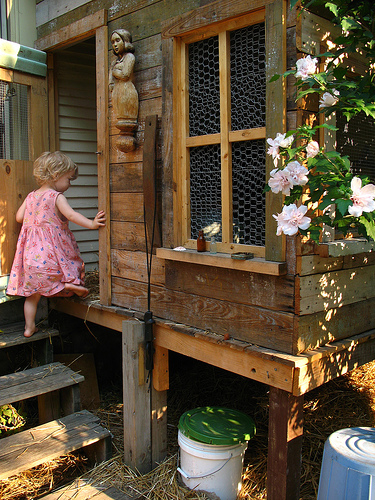

In [17]:
from IPython.display import display
from PIL import Image

# Path to your test image
test_img = "Flickr8k_Images/Flicker8k_Dataset/1000268201_693b08cb0e.jpg"

# Generate caption
caption = generate_caption(test_img, encoder, decoder, word2idx, idx2word)
print("🖼️ Generated Caption:", caption)

# Display the image
image = Image.open(test_img)
display(image)



🖼️ 3672940355_47f30e2b28.jpg
📢 Generated: a boy a soccer in baseball
📌 Reference: a girl kicks a ball | a little girl gives a good kick to a blue ball | a little girl in a pink shirt kicks a blue ball | a young girl kicking a blue ball | young girl in pink shirt kicking blue ball
🎯 BLEU Score: 0.0495


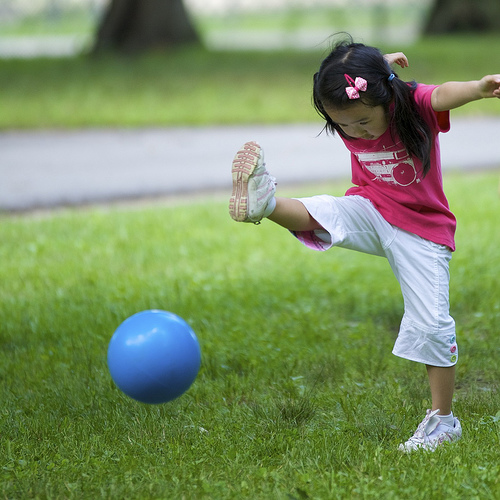


🖼️ 3558251719_3af5ae2d02.jpg
📢 Generated: a and dog a in
📌 Reference: a brown dog is standing on his back legs trying to reach something in the mans hand | a man and a dog are playing in a field | a man and a dog stand in the grass | a man holding stick and playing with a dog | the man has a dog on a leash and appears to be teaching it to stand on its hind legs
🎯 BLEU Score: 0.0307


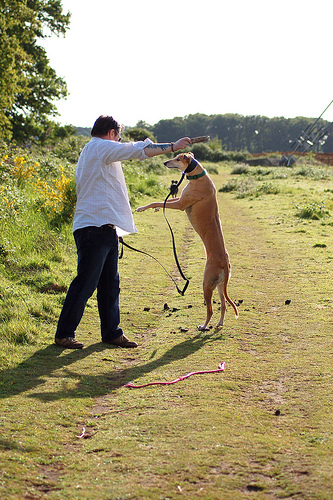


🖼️ 2465497494_43d74df57c.jpg
📢 Generated: a boy a girl a
📌 Reference: a boy plays with sand near green grass | a little boy pours sand from a shovel into a pail | a young boy in a blue shirt pours sand from one container to another | a young boy shovels sand into a mold | a young child in a blue shirt is playing with sand
🎯 BLEU Score: 0.0791


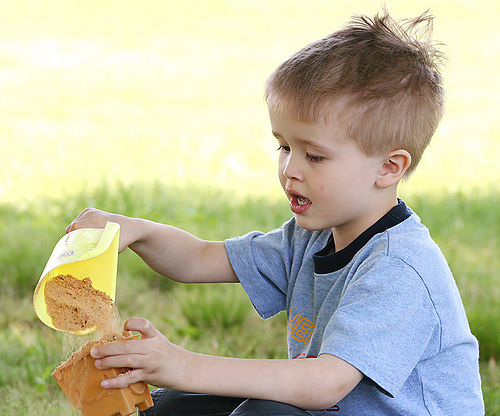

In [18]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from IPython.display import display
import random

# Pick 3 random images from dataset
sample_imgs = random.sample(list(tokenized.keys()), 3)

smoothie = SmoothingFunction().method4

for img_name in sample_imgs:
    img_path = f"Flickr8k_Images/Flicker8k_Dataset/{img_name}"

    # Generate caption
    caption = generate_caption(img_path, encoder, decoder, word2idx, idx2word)
    print(f"\n🖼️ {img_name}")
    print(f"📢 Generated: {caption}")

    # Show original captions
    ref_caps = [cap[1:-1] for cap in tokenized[img_name]]  # remove <start>/<end>
    print("📌 Reference:", ' | '.join([' '.join(c) for c in ref_caps]))

    # BLEU Score
    bleu = sentence_bleu(ref_caps, caption.split(), smoothing_function=smoothie)
    print(f"🎯 BLEU Score: {bleu:.4f}")

    # Display the image
    display(Image.open(img_path))


# New Section

Evaluating BLEU scores: 100%|██████████| 3000/3000 [00:37<00:00, 80.04it/s]


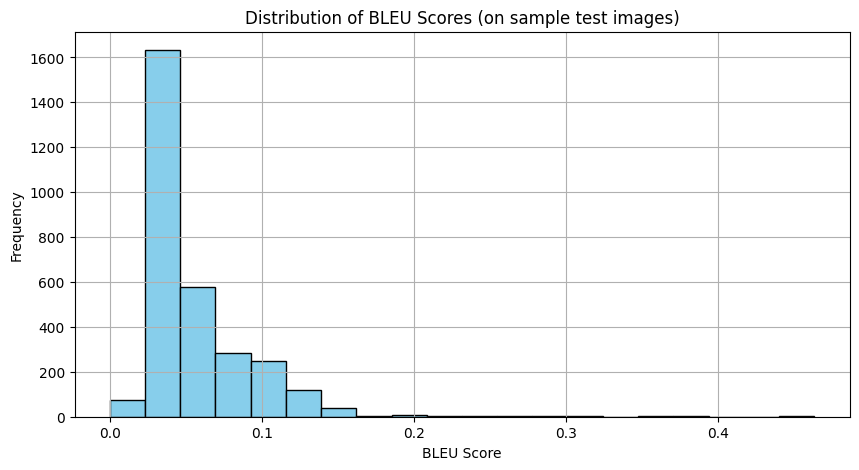

📊 Avg BLEU Score on 2999 images: 0.0562


In [20]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# BLEU evaluation setup
smoothie = SmoothingFunction().method4
bleu_scores = []
img_names = list(tokenized.keys())

# Evaluate on a limited subset for speed (e.g., 100 or 300)
sampled_imgs = img_names[:3000]  # you can change this value based on your compute

for img_name in tqdm(sampled_imgs, desc="Evaluating BLEU scores"):
    img_path = f"Flickr8k_Images/Flicker8k_Dataset/{img_name}"

    try:
        caption = generate_caption(img_path, encoder, decoder, word2idx, idx2word)
        references = [cap[1:-1] for cap in tokenized[img_name]]  # remove <start>, <end>
        hypothesis = caption.split()
        bleu = sentence_bleu(references, hypothesis, smoothing_function=smoothie)
        bleu_scores.append(bleu)
    except:
        continue  # skip unreadable or corrupt images

# Plot BLEU scores
plt.figure(figsize=(10, 5))
plt.hist(bleu_scores, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of BLEU Scores (on sample test images)")
plt.xlabel("BLEU Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

print(f"📊 Avg BLEU Score on {len(bleu_scores)} images: {sum(bleu_scores)/len(bleu_scores):.4f}")
